# Structure and Surprise in Lana Del Rey’s Lyrics and Poetry

This notebook analyzes song lyrics and poetry using lexical, structural,
and phonetic features. We compare albums across a structure–surprise
space and examine how sound-based structure operates differently in poetry.



In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [70]:
ALBUM_YEARS = {
    # Lana Del Rey albums
    "aka_lizzy_grant": 2010,
    "born_to_die": 2012,
    "ultraviolence": 2014,
    "honeymoon": 2015,
    "lust_for_life": 2017,
    "nfr": 2019,
    "chemtrails_over_the_country_club": 2021,
    "blue_banisters": 2021,
    "did_you_know_ocean_blvd": 2023,

    # Stevie Nicks/Fleetwood Mac Albums
    "rumours": 1977,
    "say_you_will": 2003,
    "street_angel": 1994,

    # Halsey Albums
    "badlands": 2015,
    "hopeless_fountain_kingdom": 2017,
    "manic": 2020,
    "if_i_cant_have_love_i_want_power": 2021,

    # Poetry
    "ariel": 1965,
    "violet_bent_backwards_over_the_grass": 2020,
    "ocean_vuong_poetry": 2019,
    "my_poetry": 2025,
    "the_colossus": 1960
}


In [71]:
import pandas as pd

# 1) Load the features table (adjust path if needed)
df = pd.read_csv("../data/features/song_features.csv")

# 2) Define which "albums" are actually poetry collections
POETRY_ALBUMS = {
    "ariel",
    "violet_bent_backwards_over_the_grass",
    "my_poetry",
    "ocean_vuong_poetry",
    "the_colossus",
}

LANA_ALBUMS = {
    "aka_lizzy_grant",
    "born_to_die",
    "ultraviolence",
    "honeymoon",
    "lust_for_life",
    "nfr",
    "chemtrails_over_the_country_club",
    "blue_banisters",
    "did_you_know_ocean_blvd",
}

STEVIE_ALBUMS = {
    "rumours",
    "say_you_will",
    "street_angel",
}

HALSEY_ALBUMS = {
    "badlands",
    "hopeless_fountain_kingdom",
    "manic",
    "if_i_cant_have_love_i_want_power",
}



# 3) Ensure a text_type column exists (no KeyError ever again)
df["text_type"] = df["album"].apply(lambda a: "poem" if a in POETRY_ALBUMS else "song")



def classify_artist(album):
    if album in LANA_ALBUMS:
        return "lana"
    elif album in STEVIE_ALBUMS:
        return "stevie"
    elif album in HALSEY_ALBUMS:
        return "halsey"
    else:
        return "other"

df["artist_group"] = df["album"].apply(classify_artist)

df["year"] = df["album"].map(ALBUM_YEARS)
df[["album", "year"]].drop_duplicates().sort_values("year")


# 4) Clean splits you can reuse everywhere
df_songs = df[df["text_type"] == "song"].copy()
df_poems = df[df["text_type"] == "poem"].copy()

df_lana = df_songs[df_songs["artist_group"] == "lana"]
df_stevie = df_songs[df_songs["artist_group"] == "stevie"]
df_halsey



# 5) Quick sanity checks (so you can trust it)
print(df["text_type"].value_counts())
print("Song albums:", sorted(df_songs["album"].unique()))
print("Poetry collections:", sorted(df_poems["album"].unique()))


text_type
song    203
poem     71
Name: count, dtype: int64
Song albums: ['aka_lizzy_grant', 'badlands', 'blue_banisters', 'born_to_die', 'chemtrails_over_the_country_club', 'did_you_know_ocean_blvd', 'honeymoon', 'hopeless_fountain_kingdom', 'lust_for_life', 'nfr', 'rumours', 'say_you_will', 'street_angel', 'ultraviolence']
Poetry collections: ['ariel', 'my_poetry', 'ocean_vuong_poetry', 'the_colossus', 'violet_bent_backwards_over_the_grass']


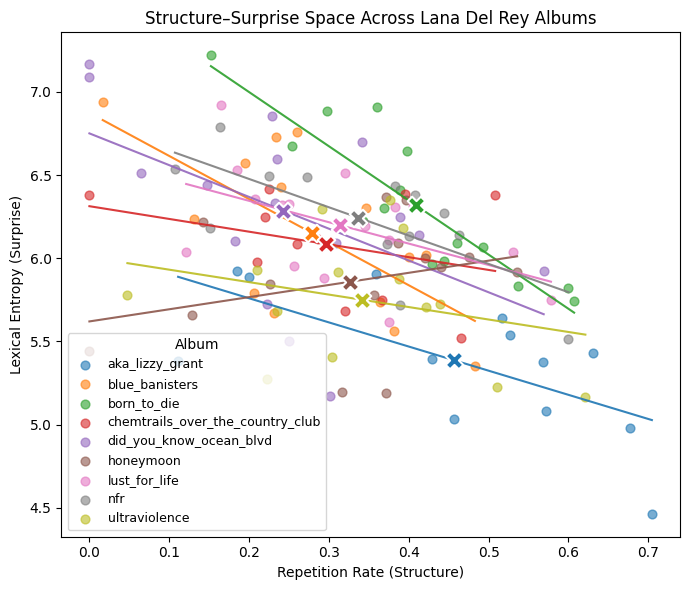

In [72]:
plt.figure(figsize=(7, 6))

for album in sorted(df_lana["album"].unique()):
    sub = df_lana[df_lana["album"] == album]

    plt.scatter(
        sub["repetition_rate"],
        sub["lexical_entropy"],
        s=40,
        alpha=0.6,
        label=album
    )

    if len(sub) > 1:
        x = sub["repetition_rate"].values
        y = sub["lexical_entropy"].values
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        ys = m * xs + b

        line, = plt.plot(xs, ys, alpha=0.9)
        line_color = line.get_color()


    mean_x = x.mean()
    mean_y = y.mean()

    plt.scatter(
    mean_x,
    mean_y,
    marker="X",
    s=160,
    color=line_color,
    edgecolor="white",
    linewidth=1.5,
    zorder=6
)


plt.xlabel("Repetition Rate (Structure)")
plt.ylabel("Lexical Entropy (Surprise)")
plt.title("Structure–Surprise Space Across Lana Del Rey Albums")
plt.legend(title="Album", fontsize=9)
plt.tight_layout()
plt.show()


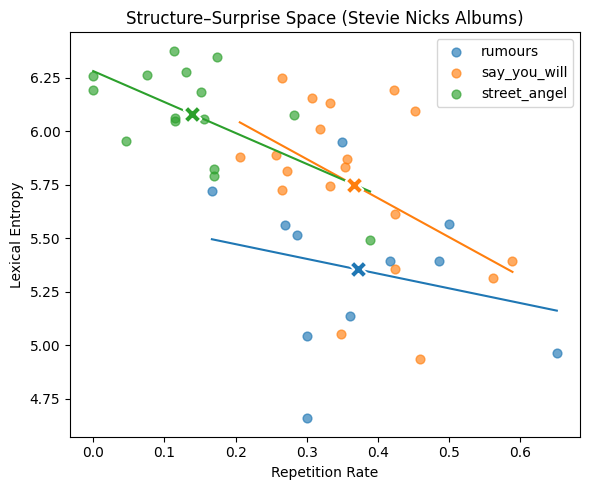

In [73]:
plt.figure(figsize=(6, 5))

for album in sorted(df_stevie["album"].unique()):
    sub = df_stevie[df_stevie["album"] == album]

    # scatter points
    plt.scatter(
        sub["repetition_rate"],
        sub["lexical_entropy"],
        s=40,
        alpha=0.65,
        label=album
    )

    # means (always safe)
    mean_x = sub["repetition_rate"].mean()
    mean_y = sub["lexical_entropy"].mean()

    if len(sub) > 1:
        x = sub["repetition_rate"].values
        y = sub["lexical_entropy"].values

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)

        line, = plt.plot(xs, m * xs + b)
        line_color = line.get_color()
    else:
        line_color = "black"

    # centroid X (matches line color)
    plt.scatter(
        mean_x,
        mean_y,
        marker="X",
        s=160,
        color=line_color,
        edgecolor="white",
        linewidth=1.5,
        zorder=6
    )

plt.xlabel("Repetition Rate")
plt.ylabel("Lexical Entropy")
plt.title("Structure–Surprise Space (Stevie Nicks Albums)")
plt.legend()
plt.tight_layout()
plt.show()


In [74]:
plt.figure(figsize=(6, 5))

for album in sorted(df_halsey["album"].unique()):
    sub = df_halsey[df_halsey["album"] == album]

    # scatter points
    plt.scatter(
        sub["repetition_rate"],
        sub["lexical_entropy"],
        s=40,
        alpha=0.65,
        label=album
    )

    # means (always safe)
    mean_x = sub["repetition_rate"].mean()
    mean_y = sub["lexical_entropy"].mean()

    if len(sub) > 1:
        x = sub["repetition_rate"].values
        y = sub["lexical_entropy"].values

        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)

        line, = plt.plot(xs, m * xs + b)
        line_color = line.get_color()
    else:
        line_color = "black"

    # centroid X (matches line color)
    plt.scatter(
        mean_x,
        mean_y,
        marker="X",
        s=160,
        color=line_color,
        edgecolor="white",
        linewidth=1.5,
        zorder=6
    )

plt.xlabel("Repetition Rate")
plt.ylabel("Lexical Entropy")
plt.title("Structure–Surprise Space (Halsey Albums)")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'df_halsey' is not defined

<Figure size 600x500 with 0 Axes>

## Song Albums: Structure vs. Surprise

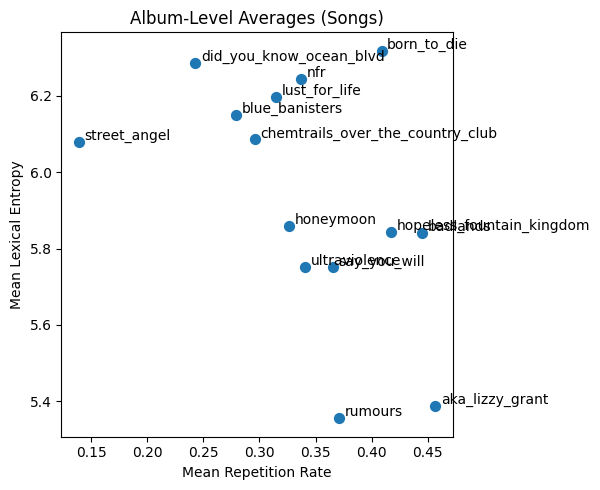

In [49]:
song_means = (
    df_songs
    .groupby("album")[["repetition_rate", "lexical_entropy"]]
    .mean()
    .reset_index()
)




plt.figure(figsize=(6, 5))
plt.scatter(
    song_means["repetition_rate"],
    song_means["lexical_entropy"],
    s=50
)

for _, row in song_means.iterrows():
    plt.text(
        row["repetition_rate"] + 0.005,
        row["lexical_entropy"] + 0.005,
        row["album"]
    )

plt.xlabel("Mean Repetition Rate")
plt.ylabel("Mean Lexical Entropy")
plt.title("Album-Level Averages (Songs)")
plt.tight_layout()
plt.show()


In [50]:
pip install pronouncing

Note: you may need to restart the kernel to use updated packages.


In [51]:
centroids = (
    df.groupby(["text_type", "album"], as_index=False)
      .agg({
          "phonetic_repetition_rate": "mean",
          "phonetic_entropy": "mean"
      })
)


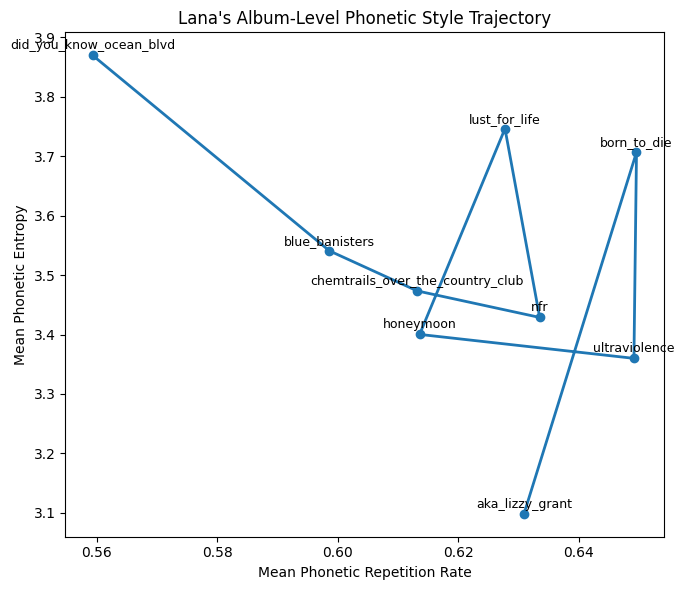

In [52]:
lana_centroids = (
    centroids[centroids["album"].isin(LANA_ALBUMS)]
    .merge(
        df[["album", "year"]].drop_duplicates(),
        on="album",
        how="left"
    )
    .sort_values("year")
)


plt.figure(figsize=(7, 6))

plt.plot(
    lana_centroids["phonetic_repetition_rate"],
    lana_centroids["phonetic_entropy"],
    marker="o",
    linewidth=2
)

for _, row in lana_centroids.iterrows():
    plt.text(
        row["phonetic_repetition_rate"],
        row["phonetic_entropy"] + 0.01,
        row["album"],
        fontsize=9,
        ha="center"
    )

plt.xlabel("Mean Phonetic Repetition Rate")
plt.ylabel("Mean Phonetic Entropy")
plt.title("Lana's Album-Level Phonetic Style Trajectory")

plt.tight_layout()
plt.show()


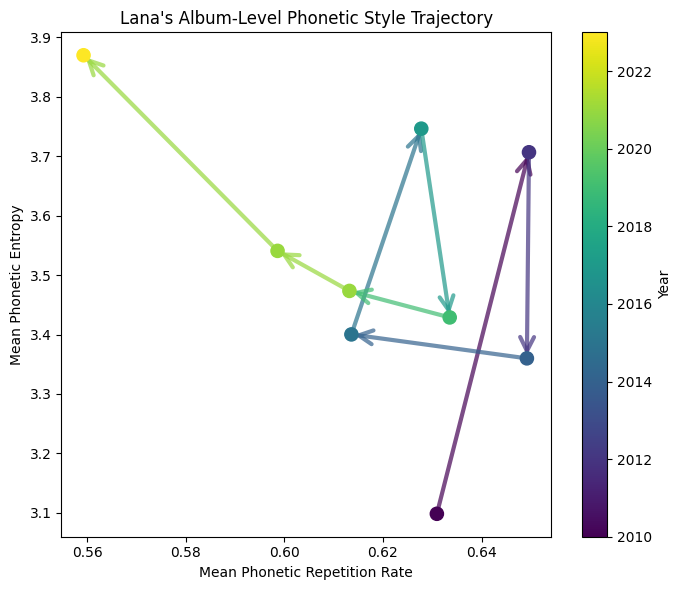

In [53]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

norm = mcolors.Normalize(
    vmin=lana_centroids["year"].min(),
    vmax=lana_centroids["year"].max()
)
cmap = cm.viridis

plt.figure(figsize=(7, 6))


for i in range(len(lana_centroids) - 1):
    x1, y1 = lana_centroids.iloc[i][["phonetic_repetition_rate", "phonetic_entropy"]]
    x2, y2 = lana_centroids.iloc[i + 1][["phonetic_repetition_rate", "phonetic_entropy"]]

    plt.annotate(
        "",
        xy=(x2, y2),
        xytext=(x1, y1),
        arrowprops=dict(
            arrowstyle="->",
            color=cmap(norm(lana_centroids.iloc[i]["year"])),
            linewidth=3,
            mutation_scale=25,
            alpha=0.7
        )
    )

plt.scatter(
    lana_centroids["phonetic_repetition_rate"],
    lana_centroids["phonetic_entropy"],
    
    c=lana_centroids["year"],
    cmap="viridis",
    s=90,
    zorder=3
)

plt.colorbar(label="Year")
plt.xlabel("Mean Phonetic Repetition Rate")
plt.ylabel("Mean Phonetic Entropy")
plt.title("Lana's Album-Level Phonetic Style Trajectory")

plt.tight_layout()
plt.show()

## Poetry: Phonetic Structure vs Surprise


In [54]:
import pronouncing
import re

def get_phonetic_ending(word):
    phones = pronouncing.phones_for_word(word.lower())
    if not phones:
        return None

    # Take first pronunciation
    phonemes = phones[0].split()

    # Get last stressed vowel onward
    for i in range(len(phonemes) - 1, -1, -1):
        if phonemes[i][-1].isdigit():  # stress marker
            return tuple(phonemes[i:])
    return tuple(phonemes[-2:])


In [55]:
def phonetic_endings(text):
    endings = []
    for line in text.split("\n"):
        words = re.findall(r"\b\w+\b", line)
        if words:
            pe = get_phonetic_ending(words[-1])
            if pe:
                endings.append(pe)
    return endings


In [56]:
from collections import Counter

def phonetic_repetition_rate(endings):
    if not endings:
        return 0
    counts = Counter(endings)
    repeats = sum(c - 1 for c in counts.values() if c > 1)
    return repeats / len(endings)


In [57]:
import math

def phonetic_entropy(endings):
    if not endings:
        return 0
    counts = Counter(endings)
    total = sum(counts.values())
    probs = [c / total for c in counts.values()]
    return -sum(p * math.log2(p) for p in probs)


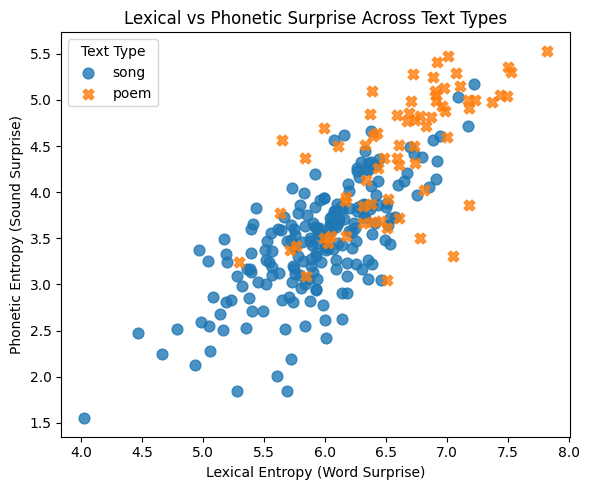

In [58]:
plt.figure(figsize=(6, 5))

for ttype, marker in [("song", "o"), ("poem", "X")]:
    sub = df[df["text_type"] == ttype]
    plt.scatter(
        sub["lexical_entropy"],
        sub["phonetic_entropy"],
        s=60,
        alpha=0.8,
        marker=marker,
        label=ttype
    )

plt.xlabel("Lexical Entropy (Word Surprise)")
plt.ylabel("Phonetic Entropy (Sound Surprise)")
plt.title("Lexical vs Phonetic Surprise Across Text Types")
plt.legend(title="Text Type")
plt.tight_layout()
plt.show()


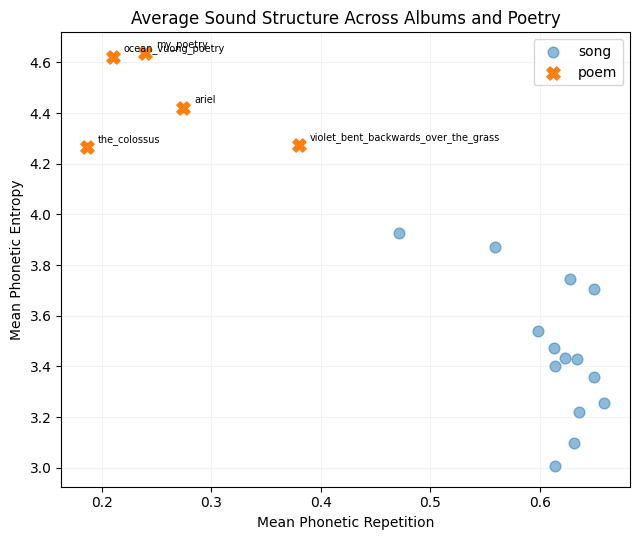

In [59]:


plt.figure(figsize=(6.5, 5.5))

# --- Songs (background) ---
songs = centroids[centroids["text_type"] == "song"]
plt.scatter(
    songs["phonetic_repetition_rate"],
    songs["phonetic_entropy"],
    s=60,
    alpha=0.5,
    color="tab:blue",
    label="song"
)

# --- Poems (foreground) ---
poems = centroids[centroids["text_type"] == "poem"]
plt.scatter(
    poems["phonetic_repetition_rate"],
    poems["phonetic_entropy"],
    s=90,
    marker="X",
    color="tab:orange",
    label="poem"
)

# Label ONLY poems
for _, row in poems.iterrows():
    plt.text(
        row["phonetic_repetition_rate"] + 0.01,
        row["phonetic_entropy"] + 0.02,
        row["album"],
        fontsize=7,
    )

plt.xlabel("Mean Phonetic Repetition")
plt.ylabel("Mean Phonetic Entropy")
plt.title("Average Sound Structure Across Albums and Poetry")

plt.legend()
plt.grid(alpha=0.15)
plt.tight_layout()
plt.show()


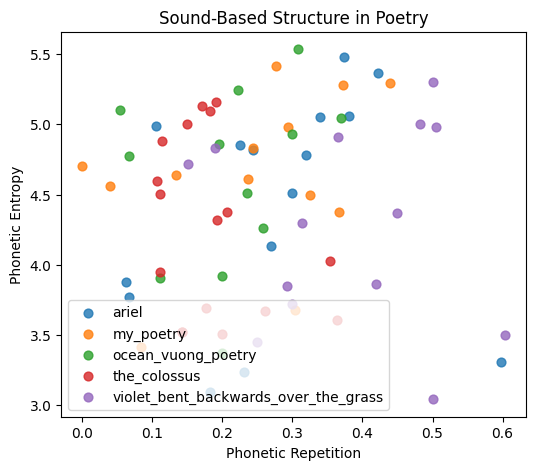

In [60]:
plt.figure(figsize=(6,5))

for collection in df_poems["album"].unique():
    sub = df_poems[df_poems["album"] == collection]
    plt.scatter(
        sub["phonetic_repetition_rate"],
        sub["phonetic_entropy"],
        s=40,
        alpha=0.8,
        label=collection
    )

plt.xlabel("Phonetic Repetition")
plt.ylabel("Phonetic Entropy")
plt.title("Sound-Based Structure in Poetry")
plt.legend()
plt.show()


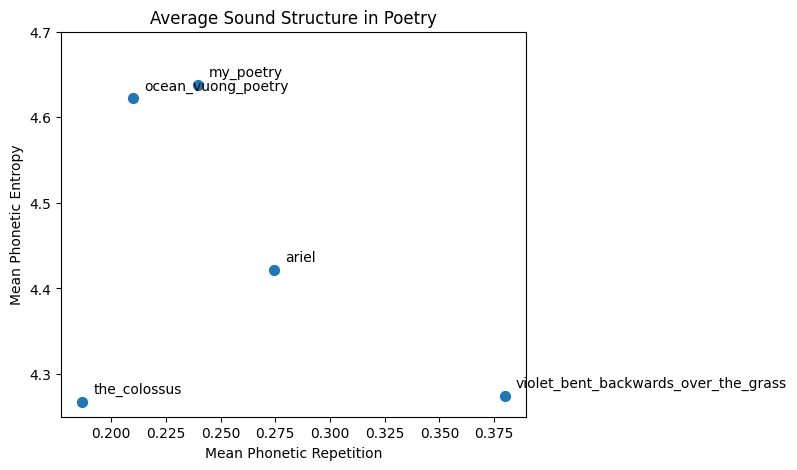

In [61]:


poem_means = (
    df_poems
    .groupby("album")[["phonetic_repetition_rate", "phonetic_entropy"]]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,5))

plt.scatter(
    poem_means["phonetic_repetition_rate"],
    poem_means["phonetic_entropy"],
    s=50
)

for _, row in poem_means.iterrows():
    plt.text(
        row["phonetic_repetition_rate"] + 0.005,
        row["phonetic_entropy"] + 0.01,
        row["album"],
        fontsize=10
    )

plt.xlabel("Mean Phonetic Repetition")
plt.ylabel("Mean Phonetic Entropy")
plt.ylim(4.25, 4.7)
plt.title("Average Sound Structure in Poetry")
plt.show()


In [62]:
!pip install seaborn


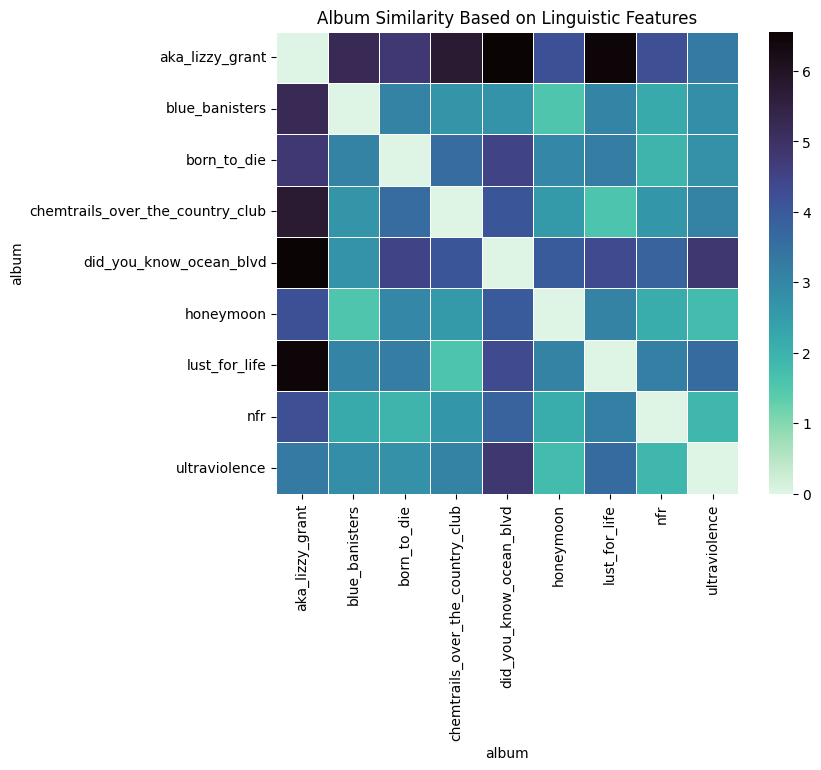

In [63]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("../data/features/song_features.csv")

# Exclude poetry if desired
songs = df[~df["album"].isin([
    "ariel",
    "violet_bent_backwards_over_the_grass",
    "my_poetry",
    "ocean_vuong_poetry",
    "the_colossus",
    "street_angel",
    "say_you_will",
    "rumours",
    "badlands",
    "hopeless_fountain_kingdom",
])]

features = [
    "repetition_rate",
    "lexical_entropy",
    "phonetic_repetition_rate",
    "phonetic_entropy",
    "first_person_rate",
    "second_person_rate"
]

album_means = songs.groupby("album")[features].mean()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(album_means)


dist_matrix = euclidean_distances(X_scaled)
dist_df = pd.DataFrame(
    dist_matrix,
    index=album_means.index,
    columns=album_means.index
)


plt.figure(figsize=(8, 6))
sns.heatmap(
    dist_df,
    cmap="mako_r",
    square=True,
    linewidths=0.5
)
plt.title("Album Similarity Based on Linguistic Features")
plt.show()
